***
*Project:* Expressive Piano Generation

*Author:* Jingwei Liu (Computer Music Ph.D., UC San Diego)
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Application & ReadMe</span> 


# Expressive Piano Performance Generation (MIDI Format)

## 1. Audio vs. MIDI

- The music scene is shifted towards audio based composition and production, thus symbolic music generation is marginalized.

- Symbolic music is frequently criticized for its stiffness and non-flexibility in generating listening-based music.

- We argue that, **under the same expressivity of music replay, MIDI as a much more concise representation has advantage over the raw audio format in generation models**.

### Multi-Arguments I/O

Five arguments are extracted from the MIDI files as sufficient statistics for expressive piano performances. The five fields are:

- Note value ($n$): a MIDI note number in range $[21,108]$.
- Time shift ($t$): the onset difference between two subsequent notes in miliseconds, $t = 0$ gives perfectly simultaneous notes.
- Duration ($d$): duration of the note in miliseconds.
- Velocity ($v$): a number in range $[0,127]$, the MIDI default velocity representation.
- Sustain pedal ($p$): the status of the sustain pedal, with binary value on/off (1/0).

In [1]:
import py_midicsv as pm
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import os
import scipy

In [2]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

## 2. Listening-based Data Processing

- *Abandonment of fixed grid.* Use time-shift events and duration measured in miliseconds to generate expressive timing.

- *A homogeneous treatment of monophony and polyphony.* We claim that there is no real simultaneity of notes. For any two notes that are played by a human performer, there is always a time discrepancy between them, no matter how unnoticeable it is. It means that, since there are no simultaneous events, **we can always place the notes in sequential order, by their time onsets.**

- *Not only the notes matter.* **The control events in MIDI may play a crucial role in musical expressivity** (eg. sustain pedal in piano generation). Please listen to "Original.MID" and "no_sustain.mid" for comparison.

- *Mel quantization of auditory features.* Instead of equal division, like the Mel spectrogram, we divide the ranges into uneven chunks to better reflect the perceptual truth. We refer to **Weber’s law** for just noticeable differences as our theoretical foundation for the divisions, where the noticeable difference is proportional to the current value.

<img src="Pictures/division_new.png" style="width:800px">
<caption><center> Figure 1. The categorical distributions for given input features. The divisions obey Weber's law where the perceptual changes are proportional to the values. </center></caption>

In [3]:
# Time Shift Division
division = np.array([2**i for i in range(16)])
division = np.append(0,division)
for j in range(3):
    for i in range(division.size-1):
        comb = division[i+1] + division[i]
        if comb % 2 == 0:
            division = np.append(division, int(comb/2))
    division = np.unique(division)
ts_division = division
ts_division = np.append(ts_division, 35000)
ts_division

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    18,
          20,    22,    24,    26,    28,    30,    32,    36,    40,
          44,    48,    52,    56,    60,    64,    72,    80,    88,
          96,   104,   112,   120,   128,   144,   160,   176,   192,
         208,   224,   240,   256,   288,   320,   352,   384,   416,
         448,   480,   512,   576,   640,   704,   768,   832,   896,
         960,  1024,  1152,  1280,  1408,  1536,  1664,  1792,  1920,
        2048,  2304,  2560,  2816,  3072,  3328,  3584,  3840,  4096,
        4608,  5120,  5632,  6144,  6656,  7168,  7680,  8192,  9216,
       10240, 11264, 12288, 13312, 14336, 15360, 16384, 18432, 20480,
       22528, 24576, 26624, 28672, 30720, 32768, 35000])

In [4]:
# Duration Division
division = np.append([0,20],np.arange(30,90,5))
division = np.append(division, np.arange(90,130,10))
division = np.append(division, np.arange(130,175,15))
division = np.append(division, np.arange(175,275,20))
division = np.append(division, np.arange(275,485,30))
division = np.append(division, np.arange(485,665,45))
division = np.append(division, np.arange(665,1015,70))
division = np.append(division, np.arange(1015,1495,120))
division = np.append(division, np.arange(1495,2095,200))
division = np.append(division, np.arange(2095,2795,350))
division = np.append(division, np.arange(2795,4395,800))
division = np.append(division, np.arange(4395,10395,1000))
division = np.append(division, np.arange(10395,31395,10000))
for i in range(2,60):
    division = np.append(division, int(np.ceil((division[i] + division[i+1])/2)))
division.sort()
dur_division = division
dur_division = np.append(dur_division, 40395)
dur_division

array([    0,    20,    30,    33,    35,    38,    40,    43,    45,
          48,    50,    53,    55,    58,    60,    63,    65,    68,
          70,    73,    75,    78,    80,    83,    85,    88,    90,
          95,   100,   105,   110,   115,   120,   125,   130,   138,
         145,   153,   160,   168,   175,   185,   195,   205,   215,
         225,   235,   245,   255,   265,   275,   290,   305,   320,
         335,   350,   365,   380,   395,   410,   425,   440,   455,
         470,   485,   508,   530,   553,   575,   598,   620,   643,
         665,   700,   735,   770,   805,   840,   875,   910,   945,
         980,  1015,  1075,  1135,  1195,  1255,  1315,  1375,  1435,
        1495,  1595,  1695,  1795,  1895,  1995,  2095,  2270,  2445,
        2620,  2795,  3195,  3595,  3995,  4395,  4895,  5395,  5895,
        6395,  6895,  7395,  7895,  8395,  8895,  9395,  9895, 10395,
       15395, 20395, 30395, 40395])

In [5]:
# Velocity Change Division
division_vel = np.append(np.arange(-22,-12,2),np.arange(-12,12))
division_vel = np.append(division_vel, np.arange(12,22,2))
division_vel = np.append(np.arange(-34,-22,4), division_vel)
division_vel = np.append(division_vel, np.arange(22,34,4))
division_vel = np.append(np.arange(-94,-34,20), division_vel)
division_vel = np.append(division_vel, np.arange(34,105,20))
vel_division = division_vel
vel_division = np.append(vel_division, 110)
vel_division

array([-94, -74, -54, -34, -30, -26, -22, -20, -18, -16, -14, -12, -11,
       -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  16,  18,
        20,  22,  26,  30,  34,  54,  74,  94, 110])

### Categorical Index of Multi-arguments

- $x_n$ -- MIDI note number minus $21$. Original range $[21,108]$, note index range $[0,87]$.

- $x_t$ -- Time shift in miliseconds categorized as Fig.1, index range $[0,104]$.

- $x_d$ -- Duration in miliseconds categorized as Fig.1, index range $[0,119]$.

- $x_v$ -- Velocity difference between two subsequent notes. Categorized as Fig.1, index range $[0,46]$

- $x_p$ -- Sustain pedal status on/off, index range $[0,1]$

## 3. Multi-arguments Sequential Model

The temporal feature of the performance is captured by the sequential model, and the multi-arguments are inherently interdependent. To model their interdependencies, we decompose the temporal predictor into 5 separate LSTMs with inputs conditioned on previous outputs.

<img src="Pictures/LSTM_5.jpg" style="width:800px">
<caption><center> Figure 2. A way to Capture Interdependency among Arguments in a Multi-argument Sequential Model.</center></caption>

The LSTM cell functions as such:

<img src="Pictures/LSTM cell.jpg" style="width:800px">
<caption><center> Figure 3. LSTM cell. A recurrent neural network with forget and update gates that capture longer time dependencies. </center></caption>

In [6]:
def softmax(x):
    if x.ndim == 1:
        e_x = torch.exp(x - torch.max(x))
        p_x = e_x / torch.sum(e_x)
    else:
        e_x = torch.exp(x - torch.max(x,axis=1,keepdims=True)[0])
        p_x = e_x / torch.sum(e_x,axis=1,keepdims=True)
    return p_x

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_len, hidden_size, num_class, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM = nn.LSTM(input_len, hidden_size, num_layers, batch_first = True, device=dev)
        self.output_layer = nn.Linear(hidden_size, num_class, device=dev)
        
    def forward(self, X, hidden_state, cell_state): # input X (batch_size, seq_len, input_len)
#         hidden_state = torch.zeros(self.num_layers, X.size(0), self.hidden_size, device = dev)
#         cell_state = torch.zeros(self.num_layers, X.size(0), self.hidden_size, device = dev)
        out, (hn, cn) = self.LSTM(X,(hidden_state, cell_state))
        out = self.output_layer(out[:,-1,:]) # output (batch_size, seq_len, output_len)
        return out, (hn, cn)

In [8]:
hidden_size = 150
num_layers = 2

input_len1 = 362 # 88+120+47+105+2
num_class1 = 88 # predict note
input_len2 = 362 + 88 
num_class2 = 105 # predict time shift
input_len3 = 362 + 193 
num_class3 = 120 # predict duration
input_len4 = 362 + 313 
num_class4 = 47 # predict velocity change
input_len5 = 362 + 360 
num_class5 = 2 # predict pedal

In [9]:
model1 = LSTM(input_len1, hidden_size, num_class1, num_layers)
model1.load_state_dict(torch.load("model1", weights_only=True))

model2 = LSTM(input_len2, hidden_size, num_class2, num_layers)
model2.load_state_dict(torch.load("model2", weights_only=True))

model3 = LSTM(input_len3, hidden_size, num_class3, num_layers)
model3.load_state_dict(torch.load("model3", weights_only=True))

model4 = LSTM(input_len4, hidden_size, num_class4, num_layers)
model4.load_state_dict(torch.load("model4", weights_only=True))

model5 = LSTM(input_len5, hidden_size, num_class5, num_layers)
model5.load_state_dict(torch.load("model5", weights_only=True))

<All keys matched successfully>

In [10]:
print(model1.eval())
print(model2.eval())
print(model3.eval())
print(model4.eval())
print(model5.eval())

LSTM(
  (LSTM): LSTM(362, 150, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=150, out_features=88, bias=True)
)
LSTM(
  (LSTM): LSTM(450, 150, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=150, out_features=105, bias=True)
)
LSTM(
  (LSTM): LSTM(555, 150, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=150, out_features=120, bias=True)
)
LSTM(
  (LSTM): LSTM(675, 150, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=150, out_features=47, bias=True)
)
LSTM(
  (LSTM): LSTM(722, 150, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=150, out_features=2, bias=True)
)


### Weight Attentions

In [11]:
model = [model1,model2,model3,model4,model5]
param_att = torch.zeros(5,9)
for i in range(param_att.shape[0]):
    param_att[i,0] = model[i].state_dict()['LSTM.weight_ih_l0'][:,:88].abs().mean() #note
    param_att[i,1] = model[i].state_dict()['LSTM.weight_ih_l0'][:,88:193].abs().mean() #time shift
    param_att[i,2] = model[i].state_dict()['LSTM.weight_ih_l0'][:,193:313].abs().mean() #duration
    param_att[i,3] = model[i].state_dict()['LSTM.weight_ih_l0'][:,313:360].abs().mean() #velocity change
    param_att[i,4] = model[i].state_dict()['LSTM.weight_ih_l0'][:,360:362].abs().mean() #pedal
    
    param_att[i,5] = model[i].state_dict()['LSTM.weight_ih_l0'][:,362:450].abs().mean() #note_next
    param_att[i,6] = model[i].state_dict()['LSTM.weight_ih_l0'][:,450:555].abs().mean() #time shift_next
    param_att[i,7] = model[i].state_dict()['LSTM.weight_ih_l0'][:,555:675].abs().mean() #duration_next
    param_att[i,8] = model[i].state_dict()['LSTM.weight_ih_l0'][:,675:722].abs().mean() #velocity change_next
param_att

tensor([[0.5571, 0.2449, 0.1943, 0.1432, 0.3097,    nan,    nan,    nan,    nan],
        [0.2960, 0.2790, 0.2210, 0.1951, 0.2938, 0.3199,    nan,    nan,    nan],
        [0.2879, 0.1886, 0.2816, 0.2105, 0.3531, 0.3178, 0.2443,    nan,    nan],
        [0.2674, 0.1855, 0.2092, 0.3011, 0.1986, 0.2990, 0.2410, 0.2203,    nan],
        [0.2441, 0.1955, 0.2190, 0.2261, 0.4684, 0.2442, 0.2115, 0.2125, 0.2353]])

In [12]:
param_att[torch.where(param_att.isnan())] = 0
1 - param_att/param_att.max(axis=1)[0].reshape(-1,1) # transparency percent

tensor([[0.0000, 0.5603, 0.6513, 0.7430, 0.4440, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.0749, 0.1279, 0.3091, 0.3903, 0.0816, 0.0000, 1.0000, 1.0000, 1.0000],
        [0.1848, 0.4660, 0.2025, 0.4039, 0.0000, 0.1000, 0.3083, 1.0000, 1.0000],
        [0.1118, 0.3838, 0.3050, 0.0000, 0.3404, 0.0069, 0.1995, 0.2684, 1.0000],
        [0.4789, 0.5827, 0.5324, 0.5172, 0.0000, 0.4786, 0.5483, 0.5464, 0.4976]])

The above matrix shows the attentions of each LSTM model on its input arguments, which can be visualized as below:
 
<img src="Pictures/LSTM_5_weight.jpg" style="width:850px">
<caption><center> Figure 4. Weight Attentions on Input Fields of 5 LSTM models.</center></caption>

- *Observation 1*: Self-attention (attention on the argument of the predictive field) generally weighs more (the blue grid above the red predictive argument).
- *Observation 2*: The 'note' field is informative in predicting all output arguments ($\hat{x}_n$ field weights comparatively higher).
- *Observation 3*: The arguments of the current note weigh more than that of the previous note (the second row has higher weights than the first row).
- *Observation 4*: The time sensitive terms (time shift, duration) rely heavily on the pedal status.

## 4. Entropy

In [13]:
def entropy(p):
    """
    Arguments: p -- row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if p.ndim == 1:
        H = (-p * torch.where(p != 0, torch.log(p), -100)).sum()
    else:
        H = (-p * torch.where(p != 0, torch.log(p), -100)).sum(axis=1,keepdims=True)
    return H

### Data Entropy

In [14]:
seq_len = 80
batch_num_tentative = 1500
batch_input = torch.zeros(batch_num_tentative, seq_len, 724, device = dev)

In [15]:
txt_folder = Path('D:\deep music\data\e_piano_index\selected').rglob('*.csv')
j = 0
for x in txt_folder:
    data_name = os.path.splitext(x)[0]
    file = "{}.csv".format(data_name)        
    Index = pd.read_csv(file, sep=",")
    
    numm = 10
    indx = np.zeros((Index.shape[0],numm),dtype = int)
    indx[:,0] = Index['Note_index']
    indx[:,1] = Index['Time_Shift_index'] + 88
    indx[:,2] = Index['Duration_index'] + 193
    indx[:,3] = Index['Velocity_index'] + 313
    indx[:,4] = Index['Pedal'] + 360
    indx[:-1,5] = Index['Note_index'][1:] + 362
    indx[:-1,6] = Index['Time_Shift_index'][1:] + 450
    indx[:-1,7] = Index['Duration_index'][1:] + 555
    indx[:-1,8] = Index['Velocity_index'][1:] + 675
    indx[:-1,9] = Index['Pedal'][1:] + 722
    indx = indx[:-1,:]
    
    file_input = torch.zeros(seq_len, 724, device = dev)
    for i in range(seq_len):
        file_input[i,indx[i]] = 1
        
    batch_input[j,:,:] = file_input
    j += 1
batch_input = batch_input[:j,:,:]
batch_num = j

In [16]:
batch_input.shape

torch.Size([1061, 80, 724])

In [17]:
hn1 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)
cn1 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)
hn2 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)
cn2 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)
hn3 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)
cn3 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)
hn4 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)
cn4 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)
hn5 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)
cn5 = torch.zeros(num_layers, batch_num, hidden_size, device = dev)

H1_data = torch.zeros(batch_num, seq_len)
H2_data = torch.zeros(batch_num, seq_len)
H3_data = torch.zeros(batch_num, seq_len)
H4_data = torch.zeros(batch_num, seq_len)
H5_data = torch.zeros(batch_num, seq_len)

In [18]:
for i in range(seq_len):
    out1, (hn1, cn1) = model1(batch_input[:,i:i+1,:362], hn1, cn1) # input (batch_size, 1, input_len)
    p1 = softmax(out1.detach())
    H1_data[:,i:i+1] = entropy(p1)
    
    out2, (hn2, cn2) = model2(batch_input[:,i:i+1,:450], hn2, cn2) # input (batch_size, 1, input_len)
    p2 = softmax(out2.detach())
    H2_data[:,i:i+1] = entropy(p2)
    
    out3, (hn3, cn3) = model3(batch_input[:,i:i+1,:555], hn3, cn3) # input (batch_size, 1, input_len)
    p3 = softmax(out3.detach())
    H3_data[:,i:i+1] = entropy(p3)
    
    out4, (hn4, cn4) = model4(batch_input[:,i:i+1,:675], hn4, cn4) # input (batch_size, 1, input_len)
    p4 = softmax(out4.detach())
    H4_data[:,i:i+1] = entropy(p4)
    
    out5, (hn5, cn5) = model5(batch_input[:,i:i+1,:722], hn5, cn5) # input (batch_size, 1, input_len)
    p5 = softmax(out5.detach())
    H5_data[:,i:i+1] = entropy(p5)

### Generation Entropy

In [19]:
gen_num1 = 1061  # number of raw generations
gen_num = gen_num1*1
init_index = np.zeros((5,gen_num),dtype=int)

In [20]:
# random initial notes
init_index[0,:] = np.random.randint(88,size=(gen_num))
init_index[1,:] = np.zeros(gen_num)
init_index[2,:] = np.random.randint(100,size=(gen_num,))
init_index[3,:] = np.random.randint(7,size=(gen_num,))+40
init_index[4,:] = np.random.randint(2,size=(gen_num,))

In [83]:
# specified initial notes
init_index = np.array([[18,0,22,43,0],
                      [41,0,31,44,0],
                      [22,0,21,43,1],
                      [52,0,73,43,0],
                      [56,0,16,45,0],
                      [35,0,29,46,0]])
init_index = np.repeat(init_index,gen_num1,axis=0).T

In [21]:
gen_len = 80 # number of notes to generate
Generate_index = np.zeros((5,gen_num,gen_len+1),dtype = int)
Generate_index[:,:,0] = init_index
ind = init_index + np.array([0,88,193,313,360]).reshape(5,1)
ind

array([[ 86,  61,  74, ...,  59,  83,  78],
       [ 88,  88,  88, ...,  88,  88,  88],
       [275, 257, 204, ..., 197, 210, 278],
       [356, 354, 353, ..., 358, 355, 355],
       [360, 361, 360, ..., 361, 360, 360]])

In [22]:
input_tensor = torch.zeros(gen_num,1,362*2,device=dev) # input (batch_size, 1, input_len)
for i in range(gen_num):
    input_tensor[i,0,ind[:,i]] = 1

In [23]:
hn1 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)
cn1 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)
hn2 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)
cn2 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)
hn3 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)
cn3 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)
hn4 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)
cn4 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)
hn5 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)
cn5 = torch.zeros(num_layers, gen_num, hidden_size,device=dev)

In [24]:
H1 = torch.zeros(gen_num, gen_len)
H2 = torch.zeros(gen_num, gen_len)
H3 = torch.zeros(gen_num, gen_len)
H4 = torch.zeros(gen_num, gen_len)
H5 = torch.zeros(gen_num, gen_len)

In [25]:
for i in range(1,gen_len+1):
    out1, (hn1, cn1) = model1(input_tensor[:,:,:362], hn1, cn1) # input (batch_size, 1, input_len)
    p1 = softmax(out1.detach())
    H1[:,i-1:i] = entropy(p1)
    for j in range(gen_num):
        note_next = np.random.choice(88, p=p1[j,:].cpu().numpy())
        input_tensor[j,:,362 + note_next] = 1
        Generate_index[0,j,i] = note_next
    
    out2, (hn2, cn2) = model2(input_tensor[:,:,:450], hn2, cn2)
    p2 = softmax(out2.detach())
    H2[:,i-1:i] = entropy(p2)
    for j in range(gen_num):
        time_shift_next = np.random.choice(105, p=p2[j,:].cpu().numpy())
        input_tensor[j,:,450 + time_shift_next] = 1
        Generate_index[1,j,i] = time_shift_next
    
    out3, (hn3, cn3) = model3(input_tensor[:,:,:555], hn3, cn3)
    p3 = softmax(out3.detach())
    H3[:,i-1:i] = entropy(p3)
    for j in range(gen_num):
        duration_next = np.random.choice(120, p=p3[j,:].cpu().numpy())
        input_tensor[j,:,555 + duration_next] = 1
        Generate_index[2,j,i] = duration_next
    
    out4, (hn4, cn4) = model4(input_tensor[:,:,:675], hn4, cn4)
    p4 = softmax(out4.detach())
    H4[:,i-1:i] = entropy(p4)
    for j in range(gen_num):
        velocity_next = np.random.choice(47, p=p4[j,:].cpu().numpy())
        input_tensor[j,:,675 + velocity_next] = 1
        Generate_index[3,j,i] = velocity_next
    
    out5, (hn5, cn5) = model5(input_tensor[:,:,:722], hn5, cn5)
    p5 = softmax(out5.detach())
    H5[:,i-1:i] = entropy(p5)
    for j in range(gen_num):
        pedal_next = np.random.choice(2, p=p5[j,:].cpu().numpy())
        input_tensor[j,:,722 + pedal_next] = 1
        Generate_index[4,j,i] = pedal_next
    
    next_tensor = torch.zeros(gen_num,1,362*2,device=dev)
    next_tensor[:,:,:362] = input_tensor[:,:,362:]
    input_tensor = next_tensor

In [26]:
Generate_index.shape

(5, 1061, 81)

## 5. Statistics

- mean
- variance
- smoothed variance

In [27]:
def stat_entropy(entropy_mtx):
    """
    Arguments:
    entropy_mtx -- torch tensor of shape (batch_size, seq_len)
    
    Returns:
    seq_mean -- mean of each sequence, torch tensor of shape (batch_size,)
    seq_var -- variance of each sequence, torch tensor of shape (batch_size,)
    avg_mtx -- moving average of each sequence, torch tensor of shape (batch_size, seq_len)
    avg_seq_var -- variance of smoothed sequence, torch tensor of shape (batch_size,)
    """
    seq_mean = entropy_mtx.mean(axis=1)
    seq_var = ((entropy_mtx - entropy_mtx.mean(axis=1,keepdims=True))**2).mean(axis=1)
    avg_mtx = torch.zeros(entropy_mtx.shape)
    for i in range(entropy_mtx.shape[1]):
        avg_mtx[:,i] = entropy_mtx[:,:i+1].mean(axis=1)
    avg_seq_var = ((avg_mtx - avg_mtx.mean(axis=1,keepdims=True))**2).mean(axis=1)
    return seq_mean, seq_var, avg_mtx, avg_seq_var

In [28]:
def group(values, n_bins):
    """
    Arguments:
    values -- a vector of values to be sorted and grouped, torch tensor of shape (batch_size,)
    n_bins -- number of bins, integer
    
    Returns:
    seq_mean -- mean of each sequence, torch tensor of shape (batch_size,)
    seq_var -- variance of each sequence, torch tensor of shape (batch_size,)
    avg_mtx -- moving average of each sequence, torch tensor of shape (batch_size, seq_len)
    avg_seq_var -- variance of smoothed sequence, torch tensor of shape (batch_size,)
    """
    
    values_ascent = torch.sort(values)[0]
    div = (values_ascent[-1] - values_ascent[0])/n_bins
    count = np.zeros((n_bins),dtype=int)
    n_prev = 0
    for i in range(1,n_bins+1):
        if len(torch.where(values_ascent >= values_ascent[0] + i*div)[0]) != 0:
            n = torch.where(values_ascent >= values_ascent[0] + i*div)[0][0]
        count[i-1] = n - n_prev
        n_prev = n
    return values_ascent, div, count

In [47]:
def plot_prob(data_values, gen_values, n_bins, ax):
    """
    Arguments:
    data_values -- a vector of statistic values of data, torch tensor of shape (batch_size_data,)
    gen_values -- a vector of statistic values of generations, torch tensor of shape (batch_size_gen,)
    n_bins -- number of bins, integer
    ax -- plot axis
    
    Returns:
    ax -- plot axis
    P -- probability of generations w.r.t data distribution, torch tensor of shape (batch_size_gen,)
    """
    data_ascent, div_data, count_data = group(data_values, n_bins)
    gen_ascent, div_gen, count_gen = group(gen_values, n_bins)
    ax.bar(np.arange(data_ascent[0]+div_data/2,data_ascent[-1],div_data), count_data, width=div_data, edgecolor="white", linewidth=0.7, label="Data")
    ax.stem(np.arange(gen_ascent[0]+div_gen/2,gen_ascent[-1],div_gen), count_gen, linefmt='orange', label="Generation")
    
    rangee = torch.arange(data_ascent[0],data_ascent[-1]+div_data/2,div_data)
    P = torch.zeros(gen_values.shape[0])
    max_num = count_data.max()
    for i in range(gen_values.shape[0]):
        if len(torch.where(rangee >= gen_values[i])[0]) != 0 and torch.where(rangee >= gen_values[i])[0][0] != 0:
            P[i] = count_data[torch.where(rangee >= gen_values[i])[0][0]-1]/max_num
    return ax, P

In [48]:
entropy_data = H1_data  # (batch_size, seq_len)
entropy_gen = H1
data_mean, data_var, avg_data, avg_data_var = stat_entropy(entropy_data)
gen_mean, gen_var, avg_gen, avg_gen_var = stat_entropy(entropy_gen)
noise = torch.randn(entropy_data.shape[0],entropy_data.shape[1])*np.sqrt(data_var.mean()) + data_mean.mean()
noise_mean, noise_var, avg_noise, avg_noise_var = stat_entropy(noise)

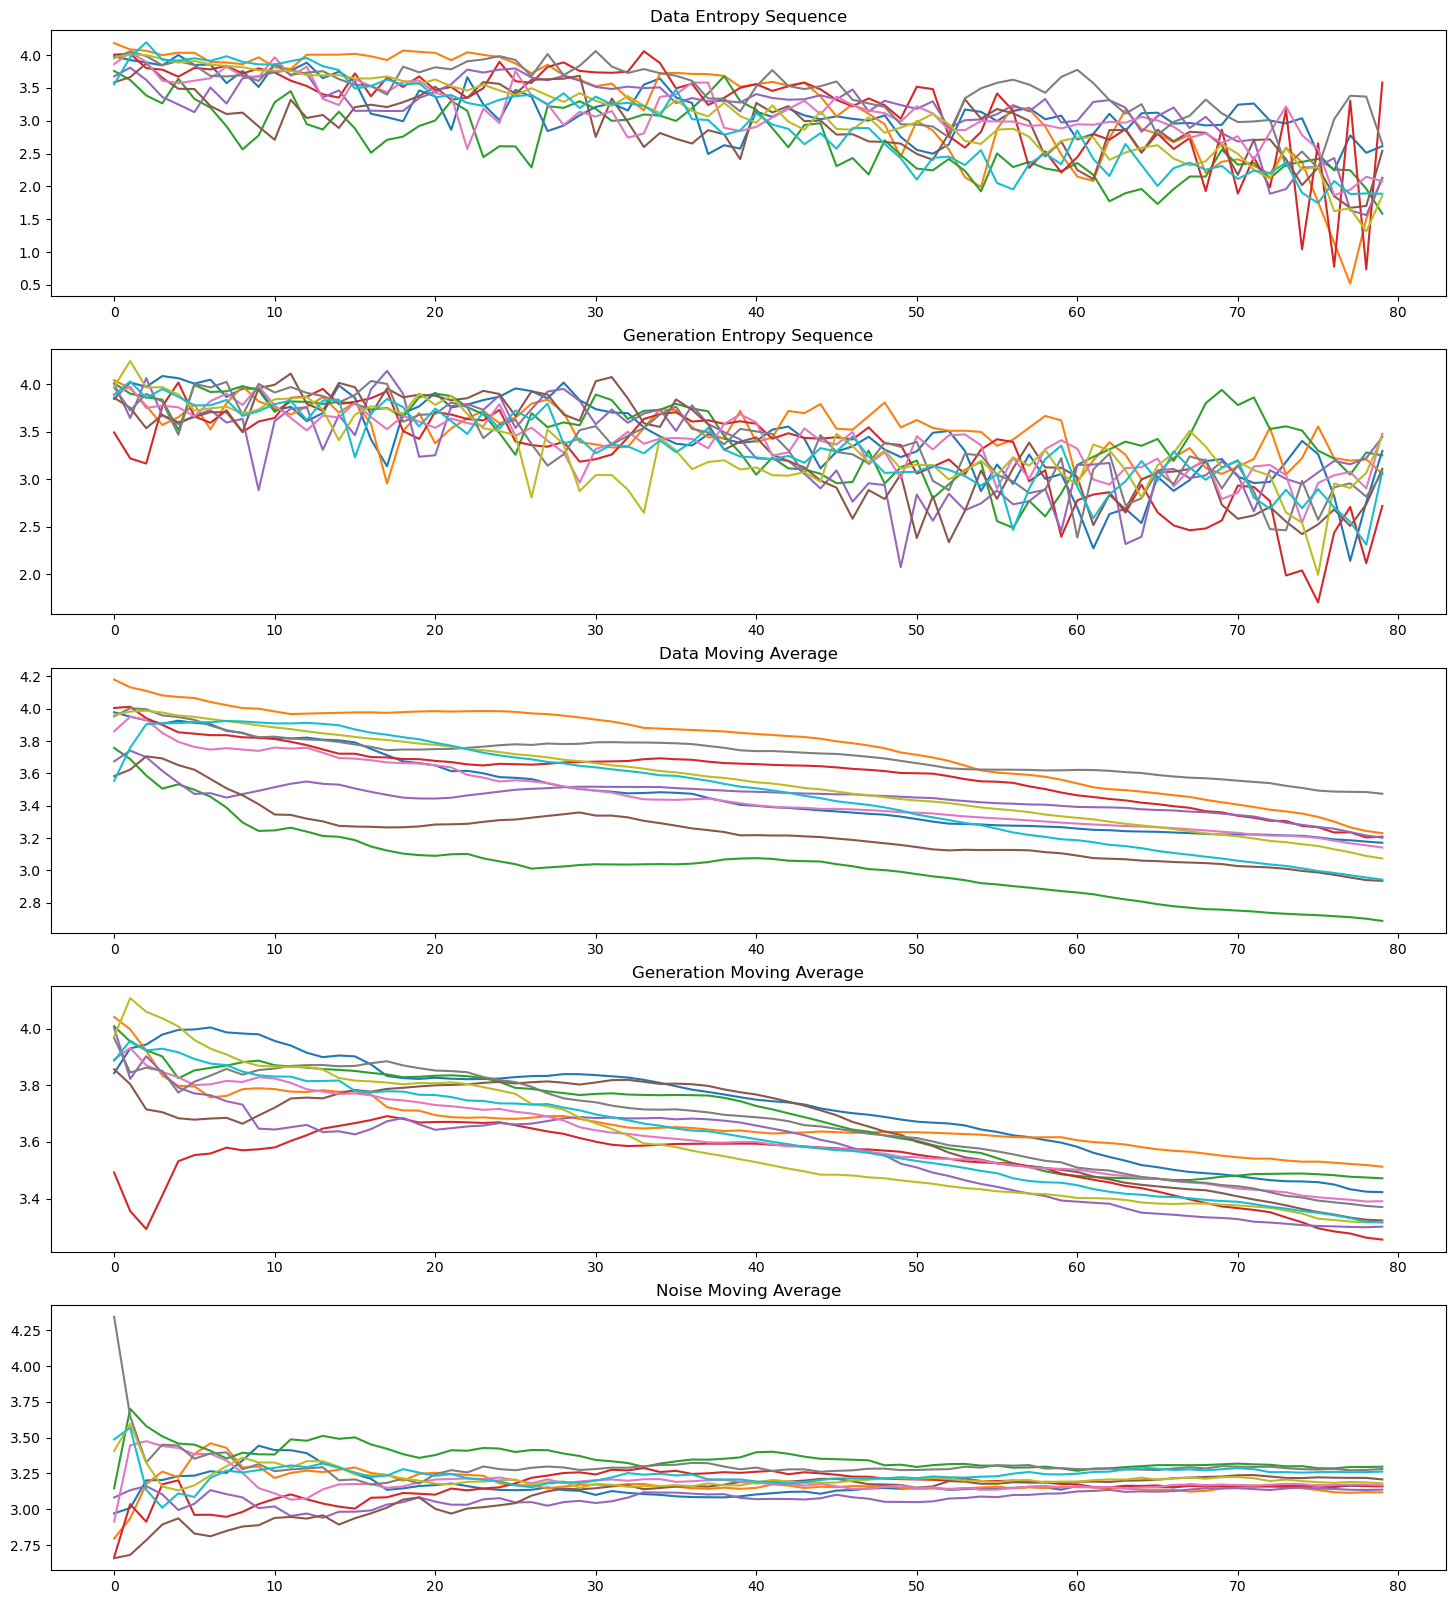

In [49]:
fig, ax = plt.subplots(5,1,figsize=(18, 20))
for i in range(5,15):
    ax[0].plot(np.arange(entropy_data.shape[1]),entropy_data[i,:])
    ax[1].plot(np.arange(entropy_gen.shape[1]),entropy_gen[i,:])
    ax[2].plot(np.arange(avg_data.shape[1]),avg_data[i,:])
    ax[3].plot(np.arange(avg_gen.shape[1]),avg_gen[i,:])
    ax[4].plot(np.arange(avg_noise.shape[1]),avg_noise[i,:])
ax[0].set_title('Data Entropy Sequence')
ax[1].set_title('Generation Entropy Sequence')
ax[2].set_title('Data Moving Average')
ax[3].set_title('Generation Moving Average')
ax[4].set_title('Noise Moving Average')
plt.show()

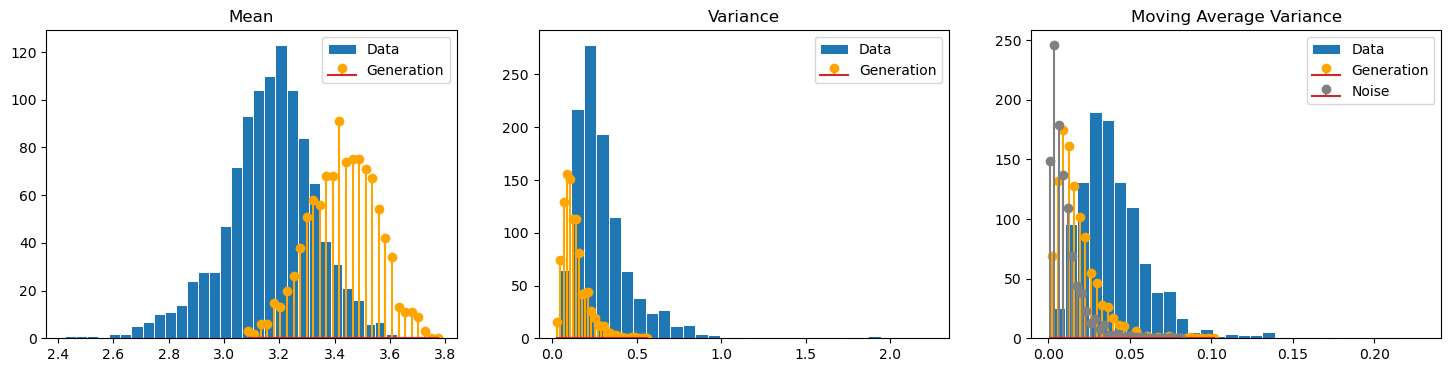

In [50]:
n_bins = 30
fig, ax = plt.subplots(1,3,figsize=(18, 4))
ax[0], P_mean = plot_prob(data_mean, gen_mean, n_bins, ax[0])
ax[0].set_title('Mean')
ax[0].legend()
ax[1], P_var = plot_prob(data_var, gen_var, n_bins, ax[1])
ax[1].set_title('Variance')
ax[1].legend()
ax[2], P_avg_var = plot_prob(avg_data_var, avg_gen_var, n_bins, ax[2])
noise_ascent, div_noise, count_noise = group(avg_noise_var, n_bins)
ax[2].stem(np.arange(noise_ascent[0],noise_ascent[-1]-div_noise/2,div_noise), count_noise, linefmt='gray', label="Noise")
ax[2].set_title('Moving Average Variance')
ax[2].legend()
plt.show()

In [51]:
Entropy_data = {}
Entropy_gen = {}

Entropy_data[0] = H1_data
Entropy_data[1] = H2_data
Entropy_data[2] = H3_data
Entropy_data[3] = H4_data
Entropy_data[4] = H5_data

Entropy_gen[0] = H1
Entropy_gen[1] = H2
Entropy_gen[2] = H3
Entropy_gen[3] = H4
Entropy_gen[4] = H5

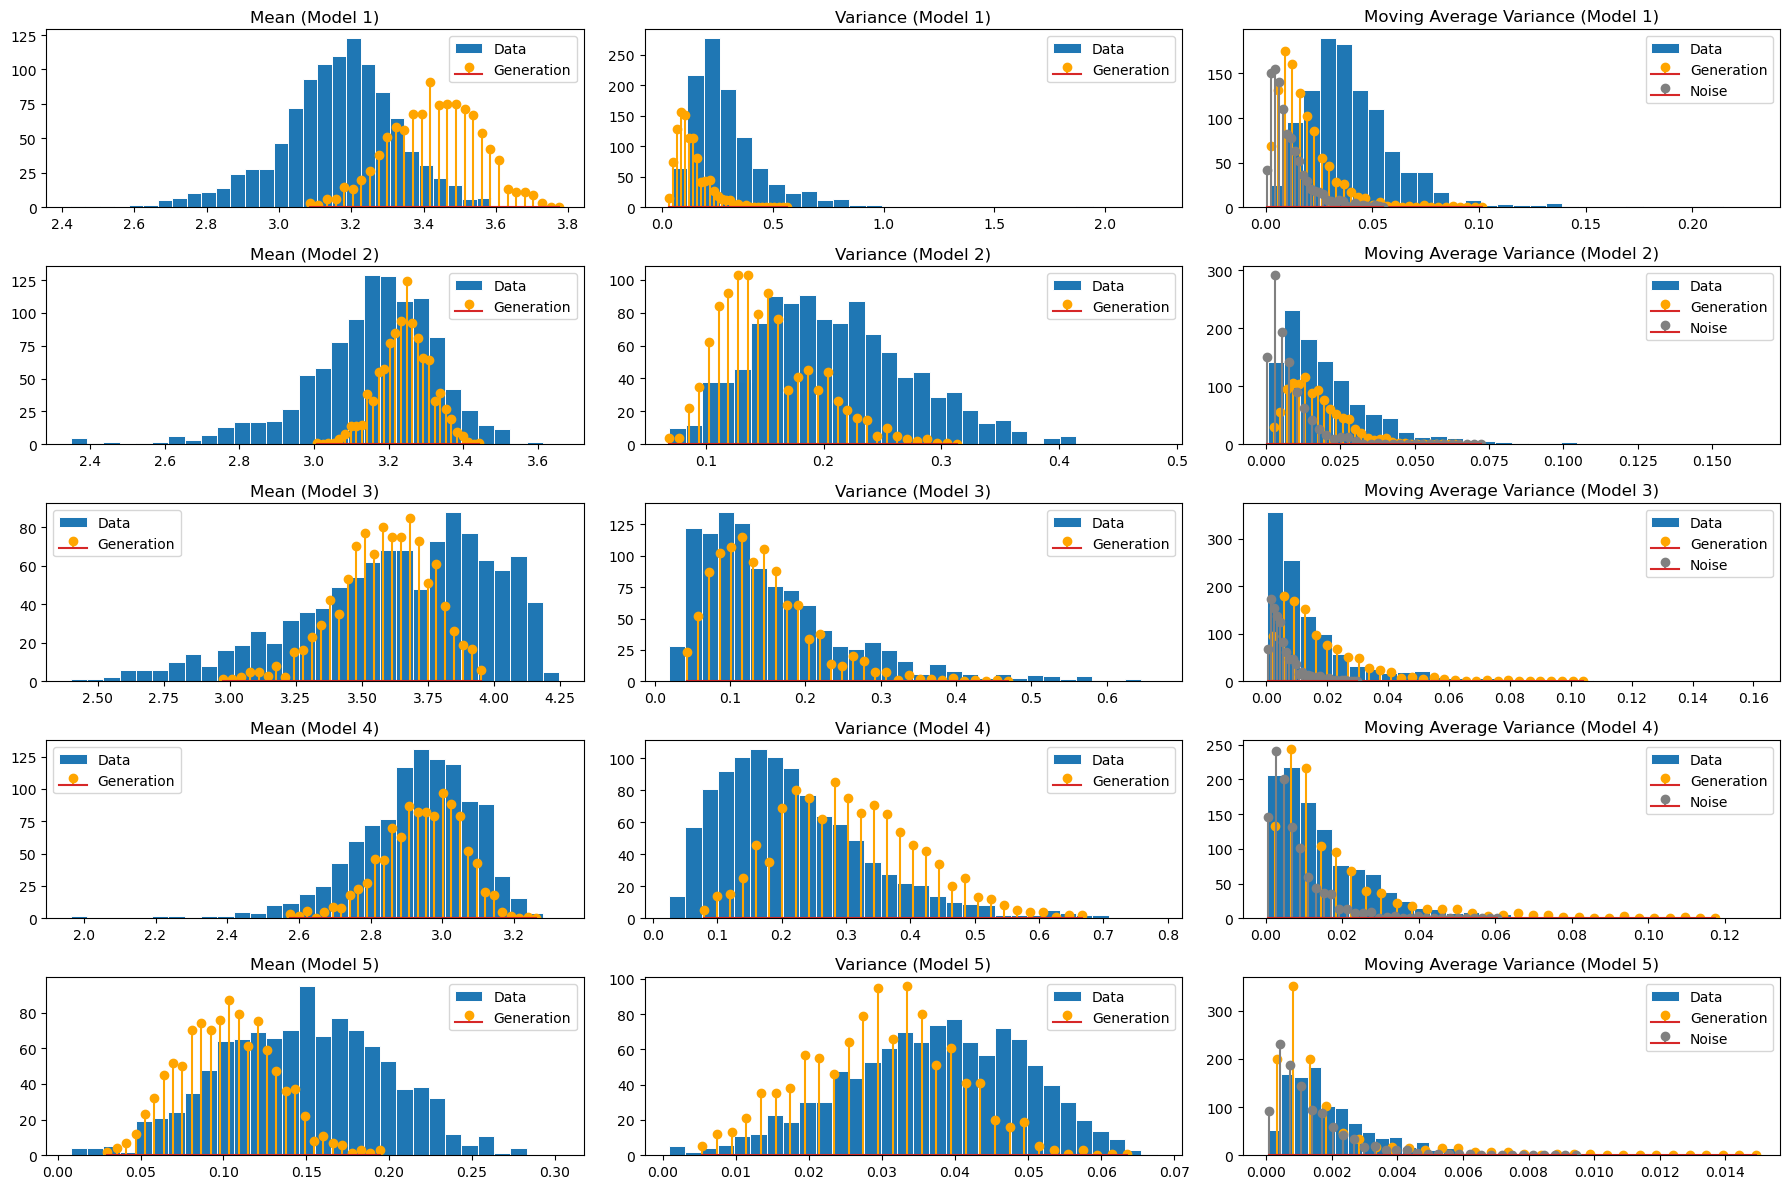

In [93]:
n_bins = 30
fig, ax = plt.subplots(5,3,figsize=(18, 12))
P_mean = torch.zeros(5,H1.shape[0])
P_var = torch.zeros(5,H1.shape[0])
P_avg_var = torch.zeros(5,H1.shape[0])
for m in range(5):
    entropy_data = Entropy_data[m]  # (batch_size, seq_len)
    entropy_gen = Entropy_gen[m]
    data_mean, data_var, avg_data, avg_data_var = stat_entropy(entropy_data)
    gen_mean, gen_var, avg_gen, avg_gen_var = stat_entropy(entropy_gen)
    noise = torch.randn(entropy_data.shape[0],entropy_data.shape[1])*np.sqrt(data_var.mean()) + data_mean.mean()
    noise_mean, noise_var, avg_noise, avg_noise_var = stat_entropy(noise)
    
    ax[m,0], P_mean[m,:] = plot_prob(data_mean, gen_mean, n_bins, ax[m,0])
    ax[m,0].set_title('Mean ('+'Model '+str(m+1) +')')
    ax[m,0].legend()
    ax[m,1], P_var[m,:] = plot_prob(data_var, gen_var, n_bins, ax[m,1])
    ax[m,1].set_title('Variance ('+'Model '+str(m+1) +')')
    ax[m,1].legend()
    ax[m,2], P_avg_var[m,:] = plot_prob(avg_data_var, avg_gen_var, n_bins, ax[m,2])
    noise_ascent, div_noise, count_noise = group(avg_noise_var, n_bins)
    ax[m,2].stem(np.arange(noise_ascent[0],noise_ascent[-1]-div_noise/2,div_noise), count_noise, linefmt='gray', label="Noise")
    ax[m,2].set_title('Moving Average Variance ('+'Model '+str(m+1) +')')
    ax[m,2].legend()    
plt.tight_layout() # plt.tight_layout(pad=3)
plt.show()

In [799]:
# # standard data bar plot
# fig, ax = plt.subplots(figsize=(18, 10))
# ax.bar(np.arange(data_mean_ascent[0]+div_data_mean/2,data_mean_ascent[-1]+div_data_mean/2,div_data_mean), count_data_mean, width=div_data_mean, edgecolor="white", linewidth=0.7)
# ax.set(xlim=(data_mean_ascent[0],data_mean_ascent[-1]), xticks=np.arange(data_mean_ascent[0],data_mean_ascent[-1]+div_data_mean/2,div_data_mean))
# plt.show()

## 6. Selection

In [45]:
Gen_mean = torch.zeros(5,H1.shape[0])
Gen_var = torch.zeros(5,H1.shape[0])
Gen_avg_var = torch.zeros(5,H1.shape[0])
weight = torch.zeros(5,1)
for m in range(5):
    entropy_gen = Entropy_gen[m]
    Gen_mean[m,:], Gen_var[m,:], avg_gen, Gen_avg_var[m,:] = stat_entropy(entropy_gen)
    weight[m,:] = Entropy_gen[m].mean() - Entropy_data[m].mean()

### 1) Minimum Summed Entropy

In [97]:
sel_num = 6
sel_ind = torch.sort((Gen_mean).mean(axis=0))[1][:sel_num]
sel_ind

tensor([ 26,  31, 170, 277, 293, 209])

### 2) Intersection with Regularization Term

In [121]:
# regularizing parameters
a = 0.1
b = 0.1
c = 0.05
index = torch.zeros(2,gen_num,dtype=int)
index[0,:] = torch.sort(Gen_mean.mean(axis=0))[1]
index[1,:] = torch.sort((Gen_mean - (P_mean*a + P_var*b + P_avg_var*c)*Gen_mean.mean(axis=1,keepdim=True)).mean(axis=0))[1]
index[:,:50]

tensor([[  26,   31,  170,  277,  293,  209,   88,  154,  809,  143,  509,  419,
          881,  663,   37, 1030,  603,  584,  432, 1039,  687,  551,  223,  963,
          260,  233,  964,  931,  938,  795,  810,  945,  337,  981,  555,  241,
          116,  882,  871,  582,  965,  137,  875,  224,  896,  215,  915,    5,
          194,  326],
        [ 297,  751,  663,  582,  963,  223,  389,  105,  933,   14,  999,  452,
          662,  637,  717,   26,  392,  871,   31,  881, 1051,  457,  284,  158,
          432,  887,  627, 1011,  167,  381,  233,  342,  922,  211,  170,   99,
         1032,  623,   89,   88,  718,  976,  636,   70,  957,  510,  903,  890,
          465,  603]])

In [124]:
sel_num = 6  # number of selected samples
for i in range(gen_num):
    ind, counts = torch.unique(index[:,:i+1],return_counts=True)
    if len(torch.where(counts != 1)[0]) >= sel_num:
        sel_ind = ind[torch.where(counts != 1)]
        break
    if i > 30:
        raise Exception("Entropy out of range. You may want to adjust the regularizing parameters.")
sel_ind

tensor([ 26,  31, 223, 663, 881, 963])

### 3.1) Union with Regularization Terms

In [278]:
sel = 8

In [279]:
ind1 = torch.sort((Gen_mean).mean(axis=0))[1][:sel]
ind1

tensor([ 26,  31, 170, 277, 293, 209,  88, 154])

In [280]:
ind2 = torch.sort((Gen_mean*torch.exp(weight)).mean(axis=0))[1][:sel]
ind2

tensor([ 26,  31, 170, 277, 293, 663,  88, 881])

In [281]:
ind3 = torch.sort(Gen_mean.mean(axis=0) + Gen_var.mean(axis=0) - Gen_avg_var.mean(axis=0))[1][:sel]
ind3

tensor([ 31,  26, 170, 154, 392,  88, 584, 663])

In [282]:
ind = torch.cat((ind1, ind2, ind3))
ind

tensor([ 26,  31, 170, 277, 293, 209,  88, 154,  26,  31, 170, 277, 293, 663,
         88, 881,  31,  26, 170, 154, 392,  88, 584, 663])

In [283]:
values,counts = torch.unique(ind, return_counts=True)
ind_uniq = values[counts.sort(descending=True)[1]]
ind_uniq

tensor([ 26,  31,  88, 170, 154, 277, 293, 663, 209, 392, 584, 881])

In [284]:
sel_num = 6  # number of selected samples
sel_ind = ind_uniq[:sel_num]
sel_ind

tensor([ 26,  31,  88, 170, 154, 277])

### 3.2) Difference with Regularization Terms

In [285]:
ind_ = torch.tensor([],dtype=int)

In [295]:
# Regularize with data (optional)
a = 0.1
b = 0.05
c = 0.03
index = torch.zeros(2,gen_num,dtype=int)
index[0,:] = torch.sort(Gen_mean.mean(axis=0))[1]
index[1,:] = torch.sort((Gen_mean - (P_mean*a + P_var*b + P_avg_var*c)*Gen_mean.mean(axis=1,keepdim=True)).mean(axis=0))[1]
for i in range(gen_num):
    ind, counts = torch.unique(index[:,:i+1],return_counts=True)
    if len(torch.where(counts != 1)[0]) >= sel:
        ind4 = torch.sort((Gen_mean - (P_mean*a + P_var*b + P_avg_var*c)*Gen_mean.mean(axis=1,keepdim=True)).mean(axis=0))[1][:sel]
        break
    if i > np.max((30, sel*8)):
        raise Exception("Entropy out of range. You may want to adjust the regularizing parameters.")
ind4

tensor([751, 999, 105, 223, 662, 280, 966, 963])

In [296]:
ind_ = torch.cat((ind_,ind4))
ind_

tensor([ 26, 663, 297, 751, 223, 963, 582, 999, 751, 297, 663, 963, 389, 223,
         26, 582,  26,  31, 297, 663,  88, 277, 233, 143, 751, 999, 105, 223,
        662, 280, 966, 963])

In [297]:
values,counts = torch.unique(ind_, return_counts=True)
ind_uniq = values[counts.sort(descending=True)[1]]
ind_uniq

tensor([ 26, 223, 297, 663, 751, 963, 582, 999,  31,  88, 105, 143, 233, 277,
        280, 389, 662, 966])

In [298]:
values,counts = torch.unique(torch.cat((ind_uniq, sel_ind)), return_counts=True)
ind_diff = values[torch.where(counts==1)]
ind_diff

tensor([105, 143, 154, 170, 223, 233, 280, 297, 389, 582, 662, 663, 751, 963,
        966, 999])

In [299]:
sel_num = 6  # number of selected samples
sel_ind_ = torch.zeros(sel_num, dtype=int)
j = 0
for i in range(len(ind_uniq)):
    if len(torch.where(ind_diff == ind_uniq[i])[0]) > 0:
        sel_ind_[j] = ind_uniq[i]
        j += 1
        if j == sel_num:
            break
sel_ind_

tensor([223, 297, 663, 751, 963, 582])

In [300]:
sel_ind = sel_ind_

## 7. Generation

### 1) Generate Concatenated Single File

In [301]:
Generate_index_sel = Generate_index[:,sel_ind[0],:]
for i in range(1,len(sel_ind)):
    Generate_index[1,sel_ind[i],0] = 80   # 4s time shift
    Generate_index_sel = np.concatenate((Generate_index_sel, Generate_index[:,sel_ind[i],:]),axis=1)
Generate_index_sel.shape

(5, 486)

In [302]:
# Transit Index to Real Value
Generation = np.zeros((5,(gen_len+1)*len(sel_ind)),dtype = int)
Generation[0,:] = Generate_index_sel[0,:] + 21 # note value
Generation[4,:] = Generate_index_sel[4,:] # pedal
vel = 0
for i in range((gen_len+1)*len(sel_ind)):
    Generation[1,i] = np.random.choice(np.arange(ts_division[Generate_index_sel[1,i]],ts_division[Generate_index_sel[1,i]+1]))
    Generation[2,i] = np.random.choice(np.arange(dur_division[Generate_index_sel[2,i]],dur_division[Generate_index_sel[2,i]+1]))
    vel_change = np.random.choice(np.arange(vel_division[Generate_index_sel[3,i]],vel_division[Generate_index_sel[3,i]+1]))
    Generation[3,i] = np.clip(vel + vel_change,20,120)
    vel = Generation[3,i]

In [303]:
# Write to MIDI file
time = np.cumsum(Generation[1,:])
MIDI_format = pd.DataFrame(columns=['Time','Type','Note','Velocity'])
pedal = 0
for i in range(Generation.shape[1]):
    MIDI_format = pd.concat([MIDI_format, pd.DataFrame([{'Time': time[i],
                         'Type': 'Note_on_c',
                         'Note': Generation[0,i],
                         'Velocity': Generation[3,i]}])], ignore_index=True)
    MIDI_format = pd.concat([MIDI_format, pd.DataFrame([{'Time': (time[i] + Generation[2,i]),
                         'Type': 'Note_off_c',
                         'Note': Generation[0,i],
                         'Velocity': 0}])], ignore_index=True)
    if Generation[4,i] != pedal:
        pedal = Generation[4,i]
        if i == 0:
            MIDI_format = pd.concat([MIDI_format, pd.DataFrame([{'Time': 0,
                                 'Type': 'Control_c',
                                 'Note': 64,
                                 'Velocity': pedal*127}])], ignore_index=True)
        else:
            MIDI_format = pd.concat([MIDI_format, pd.DataFrame([{'Time': np.random.choice(np.arange(time[i-1],time[i]+1)),
                                 'Type': 'Control_c',
                                 'Note': 64,
                                 'Velocity': pedal*127}])], ignore_index=True)
MIDI_format = MIDI_format.sort_values('Time')
MIDI_format = MIDI_format.reset_index(drop=True)
MIDI_format

,Time,Type,Note,Velocity
0,4367,Note_on_c,24,27
1,4370,Note_on_c,21,20
2,4388,Note_on_c,23,20
3,4452,Note_off_c,21,0
4,4452,Note_off_c,23,0
...,...,...,...,...
1013,71114,Note_on_c,66,62
1014,71150,Note_off_c,54,0
1015,71197,Note_off_c,66,0
1016,71199,Note_on_c,57,57


In [304]:
generated_csv = open("midi.csv", 'w')
generated_csv.write("0,0,Header,0,1,480\n")
generated_csv.write("1,0,Start_track\n")
generated_csv.write("1,0,Tempo,480000\n")
generated_csv.write("1,0,Program_c, 0, 0\n")

for i in range(len(MIDI_format)):
    generated_csv.write("1,"+str(MIDI_format['Time'][i])+","+ MIDI_format['Type'][i] +",0,"+str(MIDI_format['Note'][i])+","+str(MIDI_format['Velocity'][i])+"\n")
    
end_time = MIDI_format['Time'][i] + 480
generated_csv.write("1," + str(end_time) +", End_track\n")
generated_csv.write("0, 0, End_of_file")
generated_csv.close()

In [305]:
# Parse the CSV output of the previous command back into a MIDI file
midi_object = pm.csv_to_midi("midi.csv")

# Save the parsed MIDI file to disk
with open("C://Users/79244/Desktop/generated_lstm.mid", "wb") as output_file:
# with open("generated_note_55_61_42_0_0_zero.mid", "wb") as output_file:
    midi_writer = pm.FileWriter(output_file)
    midi_writer.write(midi_object)

### 2) Generate Seperate Files

In [309]:
sel_ind

tensor([223, 297, 663, 751, 963, 582])

In [312]:
for s in range(len(sel_ind)):
    Generate_index_sel = Generate_index[:,sel_ind[s],:]
    Generation = np.zeros((5,gen_len+1),dtype = int)
    Generation[0,:] = Generate_index_sel[0,:] + 21 # note value
    Generation[4,:] = Generate_index_sel[4,:] # pedal
    vel = 0
    for i in range(gen_len+1):
        Generation[1,i] = np.random.choice(np.arange(ts_division[Generate_index_sel[1,i]],ts_division[Generate_index_sel[1,i]+1]))
        Generation[2,i] = np.random.choice(np.arange(dur_division[Generate_index_sel[2,i]],dur_division[Generate_index_sel[2,i]+1]))
        vel_change = np.random.choice(np.arange(vel_division[Generate_index_sel[3,i]],vel_division[Generate_index_sel[3,i]+1]))
        Generation[3,i] = np.clip(vel + vel_change,20,120)
        vel = Generation[3,i]
    
    # Write to MIDI file
    time = np.cumsum(Generation[1,:])
    MIDI_format = pd.DataFrame(columns=['Time','Type','Note','Velocity'])
    pedal = 0
    for i in range(Generation.shape[1]):
        MIDI_format = pd.concat([MIDI_format, pd.DataFrame([{'Time': time[i],
                             'Type': 'Note_on_c',
                             'Note': Generation[0,i],
                             'Velocity': Generation[3,i]}])], ignore_index=True)
        MIDI_format = pd.concat([MIDI_format, pd.DataFrame([{'Time': (time[i] + Generation[2,i]),
                             'Type': 'Note_off_c',
                             'Note': Generation[0,i],
                             'Velocity': 0}])], ignore_index=True)
        if Generation[4,i] != pedal:
            pedal = Generation[4,i]
            if i == 0:
                MIDI_format = pd.concat([MIDI_format, pd.DataFrame([{'Time': 0,
                                     'Type': 'Control_c',
                                     'Note': 64,
                                     'Velocity': pedal*127}])], ignore_index=True)
            else:
                MIDI_format = pd.concat([MIDI_format, pd.DataFrame([{'Time': np.random.choice(np.arange(time[i-1],time[i]+1)),
                                     'Type': 'Control_c',
                                     'Note': 64,
                                     'Velocity': pedal*127}])], ignore_index=True)
    MIDI_format = MIDI_format.sort_values('Time')
    MIDI_format = MIDI_format.reset_index(drop=True)
    
    generated_csv = open("midi.csv", 'w')
    generated_csv.write("0,0,Header,0,1,480\n")
    generated_csv.write("1,0,Start_track\n")
    generated_csv.write("1,0,Tempo,480000\n")
    generated_csv.write("1,0,Program_c, 0, 0\n")

    for i in range(len(MIDI_format)):
        generated_csv.write("1,"+str(MIDI_format['Time'][i])+","+ MIDI_format['Type'][i] +",0,"+str(MIDI_format['Note'][i])+","+str(MIDI_format['Velocity'][i])+"\n")

    end_time = MIDI_format['Time'][i] + 480
    generated_csv.write("1," + str(end_time) +", End_track\n")
    generated_csv.write("0, 0, End_of_file")
    generated_csv.close()
    
    # Parse the CSV output of the previous command back into a MIDI file
    midi_object = pm.csv_to_midi("midi.csv")

    # Save the parsed MIDI file to disk
    with open("C://Users/79244/Desktop/Generations/generated_["+ str(sel_ind[s].item()) + "].mid", "wb") as output_file:
    # with open("generated_note_55_61_42_0_0_zero.mid", "wb") as output_file:
        midi_writer = pm.FileWriter(output_file)
        midi_writer.write(midi_object)